This notebook models the Burgers' equation utilising both the WENO and CTCS schemes to analyse the performance of both schemes around shocks

In [1]:
using Plots
using LinearAlgebra
using BenchmarkTools
using CircularArrays

Sets the inital conditions and parameters for the simulation given the domain, including inital conditions

In [2]:
function set_initial_conditions(n, L, time, dt)
    dx = 2*L/(n-1)
    x = collect(range(-L, step=dx, length=n))
    time_steps = time / dt
    flux = CircularArray(zeros(n))
    qxᴸ = CircularArray(zeros(n))
    qxᴿ = CircularArray(zeros(n))
    q = CircularArray(zeros(n))
    qx = CircularArray(zeros(n))
    u0 = @. -sin(π*x)
    u = CircularArray(u0)
    return dx, x, time_steps, flux, qxᴸ, qxᴿ, q, qx, u0, u
end

set_initial_conditions (generic function with 1 method)

### Derivative Calculations
Implementaions of the WENO and centred differece derivaite schemes used to evaulte the Burgers' Equation

In [3]:
function centred_difference!(fprime, f, dt)
    l = length(f)
    for i in 1:l
        fprime[i] = (f[i+1]-f[i-1])/(2*dt)
    end
    return nothing
end

centred_difference! (generic function with 1 method)

In [4]:
uhalf_n(c, i) = 1/30*c[i+2] - 13/60*c[i+1] + 47/60*c[i] + 9/20*c[i-1] - 1/20*c[i-2]

u1_n(c, i) =  1/3*c[i+3] - 7/6*c[i+2] + 11/6*c[i+1]
u2_n(c, i) = -1/6*c[i+2] + 5/6*c[i+1]   +  1/3*c[i]
u3_n(c, i) =  1/3*c[i+1] + 5/6*c[i]   -  1/6*c[i-1]

β1_n(c, i) = 13/12*(c[i+3] - 2*c[i+2] + c[i+1])^2 + 1/4*(c[i+3] - 4*c[i+2] + 3*c[i+1])^2
β2_n(c, i) = 13/12*(c[i+2] - 2*c[i+1] + c[i]  )^2 + 1/4*(c[i+2] - c[i])^2
β3_n(c, i) = 13/12*(c[i+1] - 2*c[i]   + c[i-1])^2 + 1/4*(3*c[i+1] - 4*c[i] + c[i-1])^2

wbar1_n(c, i) = γ1/(ϵ + β1_n(c, i))^2
wbar2_n(c, i) = γ2/(ϵ + β2_n(c, i))^2
wbar3_n(c, i) = γ3/(ϵ + β3_n(c, i))^2

w1_n(c, i) = wbar1_n(c, i)/(wbar1_n(c, i) + wbar2_n(c, i) + wbar3_n(c, i))
w2_n(c, i) = wbar2_n(c, i)/(wbar1_n(c, i) + wbar2_n(c, i) + wbar3_n(c, i))
w3_n(c, i) = wbar3_n(c, i)/(wbar1_n(c, i) + wbar2_n(c, i) + wbar3_n(c, i))


@inline u1(c, i) = @inbounds 1/3*c[i-2] - 7/6*c[i-1] + 11/6*c[i]
@inline u2(c, i) = @inbounds -1/6*c[i-1] + 5/6*c[i] + 1/3*c[i+1]
@inline u3(c, i) = @inbounds 1/3*c[i] + 5/6*c[i+1] - 1/6*c[i+2]

@inline β1(c, i) = @inbounds 13/12*(c[i-2] - 2*c[i-1] + c[i])^2 + 1/4*(c[i-2] - 4*c[i-1] + 3*c[i])^2
@inline β2(c, i) = @inbounds 13/12*(c[i-1] - 2*c[i] + c[i+1])^2 + 1/4*(c[i-1] - c[i+1])^2
@inline β3(c, i) = @inbounds 13/12*(c[i] - 2*c[i+1] + c[i+2])^2 + 1/4*(3*c[i] - 4*c[i+1] + c[i+2])^2

const γ1 = 1/10
const γ2 = 3/5
const γ3 = 3/10
const ϵ = 1e-6

@inline wbar1(c, i) = @inbounds γ1/(ϵ + β1(c, i))^2
@inline wbar2(c, i) = @inbounds γ2/(ϵ + β2(c, i))^2
@inline wbar3(c, i) = @inbounds γ3/(ϵ + β3(c, i))^2

@inline w1(c, i) = @inbounds wbar1(c, i)/(wbar1(c, i) + wbar2(c, i) + wbar3(c, i))
@inline w2(c, i) = @inbounds wbar2(c, i)/(wbar1(c, i) + wbar2(c, i) + wbar3(c, i))
@inline w3(c, i) = @inbounds wbar3(c, i)/(wbar1(c, i) + wbar2(c, i) + wbar3(c, i))

@inline weno_interpolant(c, i) = @inbounds w1(c, i)*u1(c, i)+w2(c, i)*u2(c, i)+w3(c, i)*u3(c, i)

function weno_derivative(cprimeᴸ, cprimeᴿ, c, dx, flux, vel)
    n = length(c)
    for i = 1:n
        flux[i] = w1_n(c, i)*u1_n(c, i)+w2_n(c, i)*u2_n(c, i)+w3_n(c, i)*u3_n(c, i)
    end
    for i = 1:n
        cprimeᴿ[i+1] = @inbounds (flux[i+1]-flux[i])/dx
    end
    
    for i = 1:n
        flux[i] = w1(c, i)*u1(c, i)+w2(c, i)*u2(c, i)+w3(c, i)*u3(c, i)
    end
    for i = 1:n
        cprimeᴸ[i+1] = @inbounds (flux[i+1]-flux[i])/dx
    end
    ct = zeros(n)
    for i = 1:n
        ct[i] = @inbounds (1/2*(1-sign(vel[i])))*cprimeᴿ[i] + (1/2*(sign(vel[i])+1))*cprimeᴸ[i]
    end
    return ct
end

weno_derivative (generic function with 1 method)

### Modelling
Modelling the Burgers' Equation with the following parameters and inital conditions of a sine wave to analyse the performance of WENO and CD with shocks and sharp gradients

In [5]:
# Inital parameters
dt = 1e-2
time = 1.5
n = 50
L = 1;

┌ Info: Saved animation to 
│   fn = C:\Users\User\OneDrive - Australian National University\Documents\2020\ASC\Edited\burgers_weno.gif
└ @ Plots C:\Users\User\.julia\packages\Plots\XbAWb\src\animation.jl:104


Plots.AnimatedGif("C:\\Users\\User\\OneDrive - Australian National University\\Documents\\2020\\ASC\\Edited\\burgers_weno.gif")
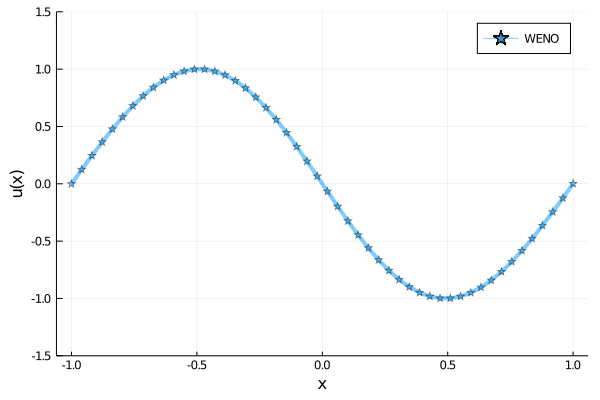

In [6]:
dx, x, time_steps, flux, qxᴸ, qxᴿ, q, qx, u0, u = set_initial_conditions(n, L, time, dt)

anim = @animate for i in 1:time_steps
    @. q = u.^2/2
    qx = weno_derivative(qxᴸ, qxᴿ, q, dx, flux, u)
    @. u = u - dt*qx
    plot(collect(x), collect(u), ylims=(-1.5,1.5), marker=:star, lw=4, alpha=0.5, 
        xlabel = "x", ylabel = "u(x)", label = "WENO")
end

gif(anim, "burgers_weno.gif", fps=300)

┌ Info: Saved animation to 
│   fn = C:\Users\User\OneDrive - Australian National University\Documents\2020\ASC\Edited\burgers_ftcs.gif
└ @ Plots C:\Users\User\.julia\packages\Plots\XbAWb\src\animation.jl:104


Plots.AnimatedGif("C:\\Users\\User\\OneDrive - Australian National University\\Documents\\2020\\ASC\\Edited\\burgers_ftcs.gif")
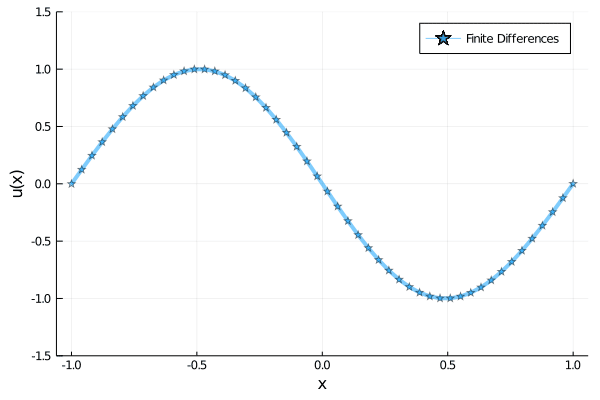

In [7]:
dx, x, time_steps, flux, qxᴸ, qxᴿ, q, qx, u0, u = set_initial_conditions(n, L, time, dt)

anim = @animate for i in 1:time_steps
    @. q = u^2/2
    centred_difference!(qx, q, dx)
    @. u = u - dt*qx
    plot(collect(x), collect(u), ylims=(-1.5,1.5), marker=:star, lw=4, alpha=0.5, 
        xlabel = "x", ylabel = "u(x)", label = "Finite Differences")
end

gif(anim, "burgers_ftcs.gif", fps=300)